In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Set Project Root

In [ ]:
import os

PROJECT_ROOT = "/content/drive/MyDrive/GalaxEye_ship_detection/galaxeye"
os.chdir(PROJECT_ROOT)

print("Working directory:", os.getcwd())
print("Content: ", os.listdir())

Working directory: /content/drive/MyDrive/GalaxEye_ship_detection/galaxeye
Content:  ['scripts', 'requirements.txt', 'yolov8s.pt', 'results', 'runs', 'data', 'yolo26n.pt']


### Installing Dependencies

In [ ]:
!pip install ultralytics rasterio opencv-python matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.6 MB/s eta 0:00:00


### Import Libraries

In [ ]:
import numpy as np
import rasterio
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Load Trained YOLO Model

In [ ]:
MODEL_PATH = "runs/detect/runs/ssdd_yolov8s/weights/best.pt"
model = YOLO(MODEL_PATH)

print("Model loaded successfully")

Model loaded successfully


### Load Sentinel-1 GeoTIFF

In [ ]:
S1_PATH = "/content/drive/MyDrive/sentinel1_exports/sentinel1_vv_panama.tif"

with rasterio.open(S1_PATH) as src:
    sar = src.read(1)
    transform = src.transform

print("SAR image shape:", sar.shape)

SAR image shape: (223, 223)


### Normalize SAR Image (CRITICAL)

In [ ]:
import gc

# Replace NaN / Inf IN-PLACE (no extra copy)
sar = np.nan_to_num(sar, nan=-25.0, posinf=0.0, neginf=-25.0)

# Clip IN-PLACE
np.clip(sar, -25, 0, out=sar)

# Normalize IN-PLACE
sar = (sar + 25) / 25

# Convert to uint8
sar_uint8 = (sar * 255).round().astype(np.uint8)

# Free unused memory
del sar
gc.collect()

5562

### Convert to 3-Channel Image

In [ ]:
sar_rgb = np.stack([sar_uint8]*3, axis=-1)

### Tile SAR Image (640×640)

In [ ]:
import cv2
import numpy as np

h, w = sar_rgb.shape[:2]

TARGET = 640
pad_h = max(0, TARGET - h)
pad_w = max(0, TARGET - w)

sar_padded = cv2.copyMakeBorder(
    sar_rgb,
    0, pad_h,
    0, pad_w,
    borderType=cv2.BORDER_CONSTANT,
    value=0  # black padding (sea-like)
)

print("Original:", (h, w))
print("Padded:", sar_padded.shape)

Original: (223, 223)
Padded: (640, 640, 3)


In [ ]:
tiles = []
coords = []

h, w = sar_padded.shape[:2]

TILE_SIZE = 320        # smaller tiles
STRIDE = 160           # 50% overlap

for y in range(0, h - TILE_SIZE + 1, STRIDE):
    for x in range(0, w - TILE_SIZE + 1, STRIDE):
        tile = sar_padded[y:y+TILE_SIZE, x:x+TILE_SIZE]
        tiles.append(tile)
        coords.append((x, y))

print("Number of tiles:", len(tiles))

Number of tiles: 9


### Run YOLO Inference on Tiles

In [ ]:
detections = []

for tile, (x0, y0) in zip(tiles, coords):
    results = model.predict(tile, conf=0.25, imgsz=640, verbose=False)

    for r in results:
        if r.boxes is None:
            continue

        boxes = r.boxes.xyxy.cpu().numpy()
        confs = r.boxes.conf.cpu().numpy()

        for (x1, y1, x2, y2), c in zip(boxes, confs):
            detections.append([
                int(x1 + x0), int(y1 + y0),
                int(x2 + x0), int(y2 + y0),
                float(c)
            ])

print("Raw detections:", len(detections))

Raw detections: 33


### Visualize Detections on SAR Image

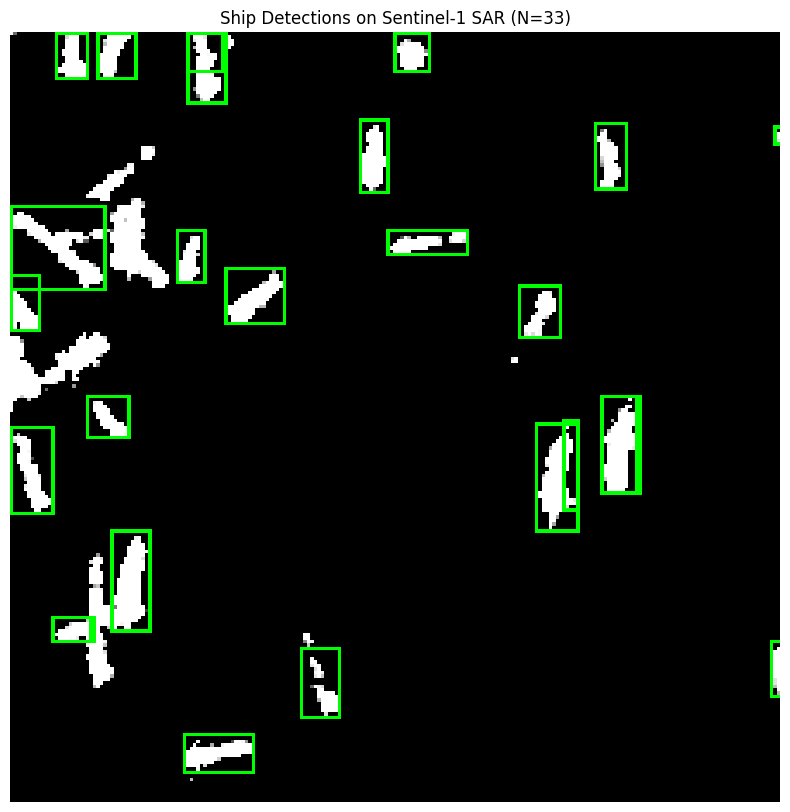

In [ ]:
vis_img = sar_rgb.copy()

BOX_THICKNESS = 1  # thin, clean boxes

for (x1, y1, x2, y2, conf) in detections:
    cv2.rectangle(
        vis_img,
        (x1, y1),
        (x2, y2),
        (0, 255, 0),
        BOX_THICKNESS
    )

plt.figure(figsize=(10, 10))
plt.imshow(vis_img, interpolation="nearest")  # crisp display
plt.title(f"Ship Detections on Sentinel-1 SAR (N={len(detections)})")
plt.axis("off")
plt.show()

####  Visualising the detected ships with the bounding box along with the confidence score

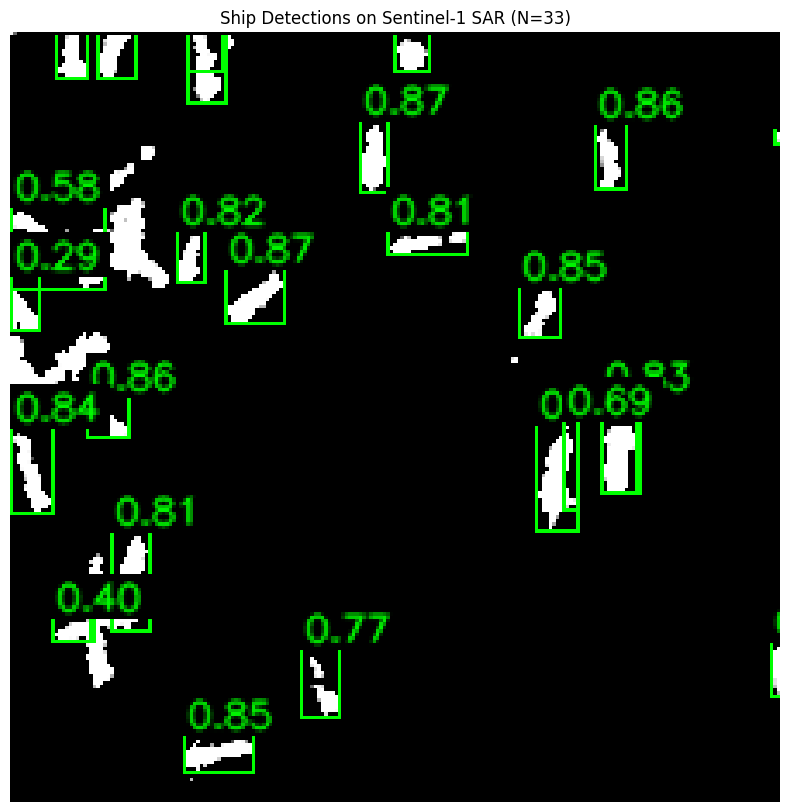

In [ ]:
vis_img = sar_rgb.copy()

BOX_THICKNESS = 1
FONT_SCALE = 0.35        # slightly larger
FONT_THICKNESS = 1

for (x1, y1, x2, y2, conf) in detections:
    # Draw bounding box
    cv2.rectangle(
        vis_img,
        (x1, y1),
        (x2, y2),
        (0, 255, 0),
        BOX_THICKNESS
    )

    # Confidence text
    label = f"{conf:.2f}"

    # Text size
    (tw, th), _ = cv2.getTextSize(
        label,
        cv2.FONT_HERSHEY_SIMPLEX,
        FONT_SCALE,
        FONT_THICKNESS
    )

    # Draw filled background rectangle for readability
    cv2.rectangle(
        vis_img,
        (x1, y1 - th - 4),
        (x1 + tw + 2, y1),
        (0, 0, 0),
        -1
    )

    # Draw text (crisp)
    cv2.putText(
        vis_img,
        label,
        (x1 + 1, y1 - 2),
        cv2.FONT_HERSHEY_SIMPLEX,
        FONT_SCALE,
        (0, 255, 0),
        FONT_THICKNESS,
        lineType=cv2.LINE_AA
    )

plt.figure(figsize=(10, 10))
plt.imshow(vis_img, interpolation="nearest")  # 🔑 CRITICAL
plt.title(f"Ship Detections on Sentinel-1 SAR (N={len(detections)})")
plt.axis("off")
plt.show()

### Save Final Visualization (IMPORTANT)

In [ ]:
OUTPUT_DIR = "results/sentinel1_inference"
os.makedirs(OUTPUT_DIR, exist_ok=True)

out_path = os.path.join(OUTPUT_DIR, "sentinel1_ship_detections_panama_box.png")
cv2.imwrite(out_path, cv2.cvtColor(vis_img, cv2.COLOR_RGB2BGR))

print("Saved result to:", out_path)

Saved result to: results/sentinel1_inference/sentinel1_ship_detections_panama_box.png


# **Applying NMS**

### STEP 0 — Small change to inference (IMPORTANT)

In [ ]:
detections = []  # [x1, y1, x2, y2, conf]

for tile, (x0, y0) in zip(tiles, coords):
    results = model.predict(tile, conf=0.25, imgsz=640, verbose=False)

    for r in results:
        if r.boxes is None:
            continue

        boxes = r.boxes.xyxy.cpu().numpy()
        scores = r.boxes.conf.cpu().numpy()

        for (x1, y1, x2, y2), conf in zip(boxes, scores):
            detections.append([
                int(x1 + x0),
                int(y1 + y0),
                int(x2 + x0),
                int(y2 + y0),
                float(conf)
            ])

print("Raw detections:", len(detections))

Raw detections: 33


### STEP 1 — Confidence Filtering

In [ ]:
CONF_THRESH = 0.5

detections_conf = [
    d for d in detections if d[4] >= CONF_THRESH
]

print("After confidence filtering:", len(detections_conf))

After confidence filtering: 30


### STEP 2 — GLOBAL NMS (CRITICAL STEP)
merging the duplicates

### NMS implementation (pure NumPy, Colab-safe)

In [ ]:
import numpy as np

def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = area1 + area2 - inter
    return inter / union if union > 0 else 0


def global_nms(dets, iou_thresh=0.5):
    dets = sorted(dets, key=lambda x: x[4], reverse=True)
    keep = []

    while dets:
        best = dets.pop(0)
        keep.append(best)

        dets = [
            d for d in dets
            if iou(best, d) < iou_thresh
        ]

    return keep

### Apply NMS

In [ ]:
nms_detections = global_nms(detections_conf, iou_thresh=0.5)

print("Final detections after NMS:", len(nms_detections))

Final detections after NMS: 22


### STEP 3 — Visualize FINAL ship detections

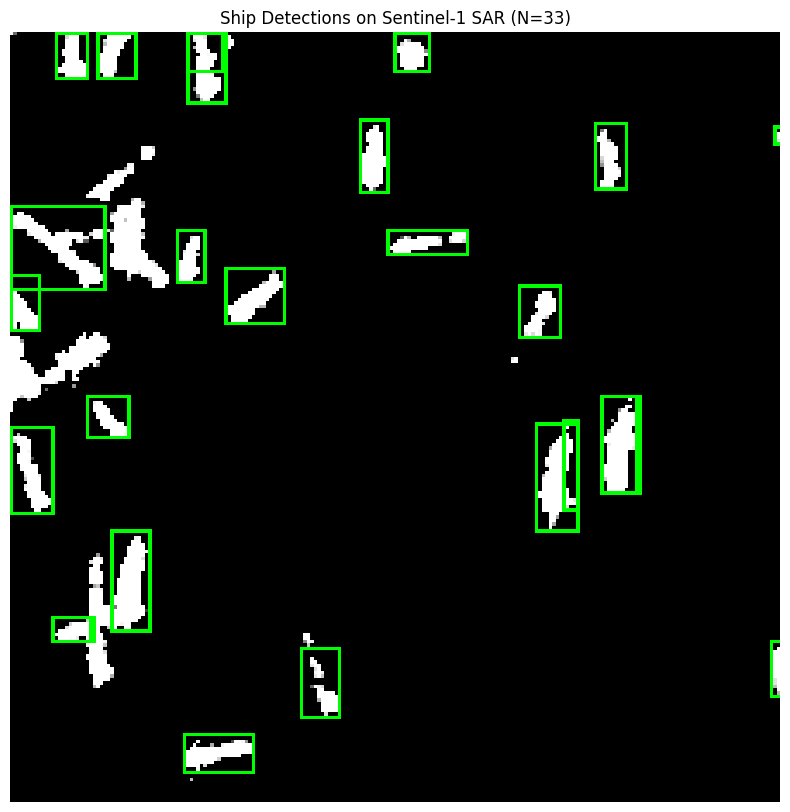

In [ ]:
final_vis = sar_rgb.copy()

BOX_THICKNESS = 1

for (x1, y1, x2, y2, conf) in nms_detections:
    cv2.rectangle(
        final_vis,
        (x1, y1),
        (x2, y2),
        (0, 255, 0),
        BOX_THICKNESS
    )

plt.figure(figsize=(10, 10))
plt.imshow(vis_img, interpolation="nearest")  # crisp display
plt.title(f"Ship Detections on Sentinel-1 SAR (N={len(detections)})")
plt.axis("off")
plt.show()

### Save final result (MANDATORY)

In [ ]:
OUTPUT_DIR = "results/sentinel1_inference"
os.makedirs(OUTPUT_DIR, exist_ok=True)

out_path = os.path.join(OUTPUT_DIR, "sentinel1_ship_detections_panama_nms_box.png")
cv2.imwrite(out_path, cv2.cvtColor(final_vis, cv2.COLOR_RGB2BGR))

print("Saved:", out_path)

Saved: results/sentinel1_inference/sentinel1_ship_detections_panama_nms_box.png
